In [1]:
# increase batch size to 128

import os
from math import floor

import Bio.SeqIO as SeqIO
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model

import sys  
sys.path.append('../../../src')
from metrics import *

from pandas.core.common import flatten

In [2]:
model_name = "jason_cnn_3_2"

In [3]:
class BatchGenerator(keras.utils.Sequence):
    """Label, batch, and pad protein sequence data.

    Only complete batches are returned, so a single epoch may not train on every example."""
    def __init__(self, records, batch_size, sym_codes, shuffle=True):
        self.records = records
        self.indices = np.arange(len(self.records))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ctable = {}  # Category table
        for i, sym_code in enumerate(sym_codes):
            self.ctable[sym_code] = i
        self.on_epoch_end()

    def __len__(self):
        """Return number of batches."""
        return floor(len(self.records) / self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data."""
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        records = [self.records[i] for i in indices]
        max_len = max([len(record[0]) for record in records])
        x = np.zeros((self.batch_size, max_len))
        y = np.zeros((self.batch_size, max_len))
        for i, (syms, labels) in enumerate(records):
            x[i, :len(syms)] = [self.ctable.get(sym, 0) for sym in syms]
            y[i, :len(syms)] = [int(label) for label in labels]

        x = keras.utils.to_categorical(x, num_classes=len(self.ctable))
        y = keras.utils.to_categorical(y, num_classes=2)
        for i, (syms, _) in enumerate(records):
            x[i, len(syms):, :] = 0
            y[i, len(syms):, :] = 0
        return x, y

    def on_epoch_end(self):
        """Shuffles data after each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)

def load_data(seqs_path, labels_path):
    # Load files
    seqs = {}
    for record in SeqIO.parse(seqs_path, 'fasta'):
        accession = record.description.split('|')[0]
        seq = str(record.seq)
        seqs[accession] = seq
    labels = {}
    for record in SeqIO.parse(labels_path, 'fasta'):
        accession = record.description.split('|')[0]
        label = str(record.seq)
        labels[accession] = label

    # Bundle seqs and labels into single object
    records = []
    for accession, seq in seqs.items():
        records.append((seq, labels[accession]))

    return records

def decode_sym(batch, sym_codes):
    """Decodes residue symbols in batch of proteins from encoded form."""
    ctable, i = {}, 0
    for sym_code in sym_codes:
        ctable[i] = sym_code
        i += 1
        
    decoded_sym = []
    for protein in batch:
        decoded_protein = []
        for residue in protein:
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = ctable[np.argmax(residue)]
                decoded_protein.append(decoded_residue)
        decoded_sym.append("".join(decoded_protein))
                           
    return decoded_sym

def decode_label_by_protein(batch_to_be_decoded, original_batch):
    """
    Decodes residue labels in batch of proteins from encoded form.
    Outputs list of str where each str is labels of one protein.
    
    batch_to_be_decoded:
    batch of labels which want to be decoded
    
    original_batch:
    original batch of labels generated by BatchGenerator which
    batch_to_be_decoded is derived from (this is needed in order
    to remove unwanted masked values)
    """
    decoded_labels = []
    for x in np.arange(len(original_batch)):
        protein = original_batch[x]
        decoded_protein = []
        for y in np.arange(len(protein)):
            residue = protein[y]
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = np.argmax(batch_to_be_decoded[x][y])
                decoded_protein.append(str(decoded_residue))
        decoded_labels.append("".join(decoded_protein))
    return decoded_labels

def decode_label_to_lst(batch_to_be_decoded, original_batch):
    """
    Decodes residue labels in batch of proteins from encoded form.
    Outputs list of int where each int is label for one residue.
    
    batch_to_be_decoded:
    batch of labels which want to be decoded
    
    original_batch:
    original batch of labels generated by BatchGenerator which
    batch_to_be_decoded is derived from (this is needed in order
    to remove unwanted masked values)
    """
    decoded_labels = []
    for x in np.arange(len(original_batch)):
        protein = original_batch[x]
        for y in np.arange(len(protein)):
            residue = protein[y]
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = np.argmax(batch_to_be_decoded[x][y])
                decoded_labels.append(decoded_residue)
    return decoded_labels
                           
class MaskedConv1D(keras.layers.Conv1D):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(filters, kernel_size, **kwargs)
        self.supports_masking = True

In [4]:
# Parameters
sym_codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
             'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [5]:
# Load data
train_records = load_data('../../mobidb_validation/split_data/out/train_as_fasta.fasta', '../../mobidb_validation/split_data/out/train_labels_as_fasta.fasta')
validation_records = load_data('../../mobidb_validation/split_data/out/val_as_fasta.fasta', '../../mobidb_validation/split_data/out/val_labels_as_fasta.fasta')
test_records = load_data('../../mobidb_validation/split_data/out/test_as_fasta.fasta', '../../mobidb_validation/split_data/out/test_labels_as_fasta.fasta')

In [6]:
# Batch data
train_batches = BatchGenerator(train_records, 128, sym_codes)
validation_batches = BatchGenerator(validation_records, 32, sym_codes)
test_batches = BatchGenerator(test_records, 32, sym_codes)

In [7]:
# Build model
inputs = keras.layers.Input(shape=(None, 20), name='input1')
x = layers.Masking(mask_value=0, name='mask1')(inputs)
x = MaskedConv1D(128, 20, padding='same', activation='relu', name='conv1d1')(x)
x = MaskedConv1D(128, 20, padding='same', activation='relu', name='conv1d2')(x)
outputs = layers.Dense(2, activation='softmax', name='dense1')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()

Model: "jason_cnn_3_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, None, 20)]        0         
_________________________________________________________________
mask1 (Masking)              (None, None, 20)          0         
_________________________________________________________________
conv1d1 (MaskedConv1D)       (None, None, 128)         51328     
_________________________________________________________________
conv1d2 (MaskedConv1D)       (None, None, 128)         327808    
_________________________________________________________________
dense1 (Dense)               (None, None, 2)           258       
Total params: 379,394
Trainable params: 379,394
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Train model
# Epochs are written explicitly in a training loop since Keras
# does not support generators for calculating validation metrics

num_epochs = 50

histories = []

metrics_df = pd.DataFrame()

for i in range(num_epochs):
    # Fit
    print(f'EPOCH {i}')
    history = model.fit(train_batches, epochs=1)
    histories.append(history)

    # Evaluate
    true_labels = []
    pred_labels = []
    for batch in validation_batches:
        true_labels.append(decode_label_to_lst(batch[1], batch[1]))
        pred_labels.append(decode_label_to_lst(model.predict(batch[0]), batch[1]))
    true_labels = list(flatten(true_labels))
    pred_labels = list(flatten(pred_labels))
    
    batch_metrics_df = get_binary_metrics(true_labels, pred_labels)
    print("Label Accuracy:", batch_metrics_df.loc[0].at["Accuracy"])
    
    metrics_df = metrics_df.append(batch_metrics_df, ignore_index = True)

EPOCH 0
135/135 [==============================] - 794s 6s/step - loss: 0.0341 - binary_accuracy: 0.9375
Label Accuracy: 0.9309876094421928
EPOCH 1
135/135 [==============================] - 768s 6s/step - loss: 0.0327 - binary_accuracy: 0.9385
Label Accuracy: 0.9309876094421928
EPOCH 2
135/135 [==============================] - 940s 7s/step - loss: 0.0317 - binary_accuracy: 0.9386
Label Accuracy: 0.9309876094421928
EPOCH 3
135/135 [==============================] - 1063s 8s/step - loss: 0.0314 - binary_accuracy: 0.9383
Label Accuracy: 0.9309876094421928
EPOCH 4
135/135 [==============================] - 836s 6s/step - loss: 0.0309 - binary_accuracy: 0.9383
Label Accuracy: 0.9309876094421928
EPOCH 5
135/135 [==============================] - 797s 6s/step - loss: 0.0312 - binary_accuracy: 0.9384
Label Accuracy: 0.9309876094421928
EPOCH 6
135/135 [==============================] - 805s 6s/step - loss: 0.0303 - binary_accuracy: 0.9385
Label Accuracy: 0.9309702069733626
EPOCH 7
135/135 [==

In [8]:
metrics_df

,Accuracy,MCC,Sensitivity,Specificity,Precision,F1
0,0.930988,0.000000,0.000000,1.000000,0.000000,0.000000
1,0.930988,0.000000,0.000000,1.000000,0.000000,0.000000
2,0.930988,0.000000,0.000000,1.000000,0.000000,0.000000
3,0.930988,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.930988,0.000000,0.000000,1.000000,0.000000,0.000000
5,0.930988,0.000000,0.000000,1.000000,0.000000,0.000000
6,0.930970,0.009285,0.000336,0.999956,0.363636,0.000672
7,0.930988,0.000000,0.000000,1.000000,0.000000,0.000000
8,0.930939,0.010976,0.000588,0.999904,0.313433,0.001175
9,0.930879,0.016279,0.001303,0.999787,0.312081,0.002595


In [9]:
balanced_accuracy = (metrics_df["Sensitivity"].values[49]+metrics_df["Specificity"].values[49])/2
balanced_accuracy

0.5368620201714843

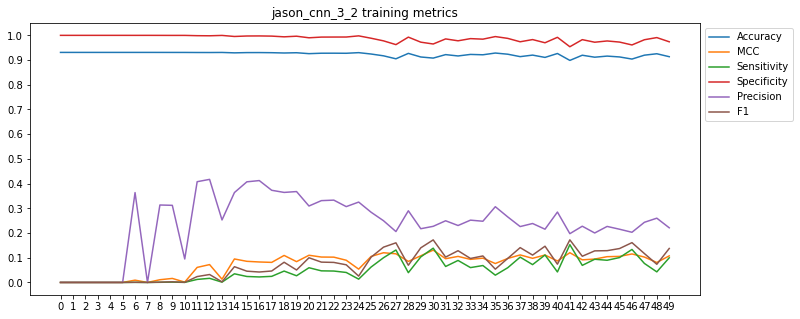

In [10]:
x_axis_ticks = np.arange(num_epochs)
y_axis_ticks = np.arange(11)/10

metrics_fig = metrics_df.plot(figsize = (12, 5), use_index = True, title = model_name + " training metrics", 
                              xticks = x_axis_ticks, yticks = y_axis_ticks)

metrics_fig = metrics_fig.legend(bbox_to_anchor=(1, 1))
metrics_fig = metrics_fig.get_figure()

In [11]:
# Save model
if not os.path.exists('out_model/'):
    os.mkdir('out_model/')

model.save('out_model/' + model_name + ".h5")

In [12]:
# Save metrics df
if not os.path.exists('out_metrics/'):
    os.mkdir('out_metrics/')

metrics_df.to_csv("out_metrics/training_metrics.csv", index=False)

In [11]:
model = load_model("out_model/" + model_name + ".h5", custom_objects={"MaskedConv1D": MaskedConv1D})

In [7]:
metrics_df = pd.read_csv ("out_metrics/training_metrics.csv")